# Referenced from: https://github.com/radical-p/Breakout_Deep_Q_Reinforcement_Learning/blob/main/Breakout_DQN.py

In [1]:
# !pip install stable-baselines3[extra] pyvirtualdisplay gym[atari] pyglet
# !pip install atari-py==0.2.5
# !apt-get install unrar

# !wget http://www.atarimania.com/roms/Roms.rar
# !unrar x Roms.rar
# !unzip ROMS.zip
# !python -m atari_py.import_roms ROMS

# import os

# os.system('apt-get update')
# os.system('apt-get install -y xvfb')
# os.system('wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall18/xvfb -O ../xvfb')
# os.system('apt-get install -y python-opengl ffmpeg')
# os.system('pip install pyglet==1.5.0')

# os.system('python -m pip install -U pygame --user')

# prefix = 'https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week04_approx_rl/'

# os.system('wget ' + prefix + 'atari_wrappers.py')
# os.system('wget ' + prefix + 'utils.py')
# os.system('wget ' + prefix + 'replay_buffer.py')
# os.system('wget ' + prefix + 'framebuffer.py')

# # print('setup complete')

# # XVFB will be launched if you run on a server
# import os
# if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
#     !bash ../xvfb start
#     os.environ['DISPLAY'] = ':1'

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment Breakout-ram-v0 is out of date. You should consider upgrading to version `v4`.
  logger.warn(


Discrete(4)
128
[255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255
 255 255]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/rmsprop.py:144: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 35ms/step
Reward: 
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Episode: 
[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250]
Average_time: 
43.836850277582805


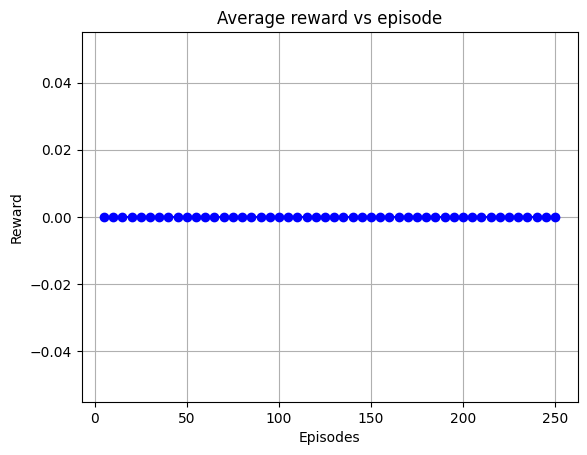

In [2]:
import random
import numpy as np
import pandas as pd
import gym
import time
from collections import deque
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import tensorflow as tf


class DQN:
    def __init__(self, env):
        # Initialize the DQN agent
        self.env = env
        self.memory = deque(maxlen=4000)  # Replay memory (Origianl: 400000)
        self.gamma = 0.9  # Discount factor for future rewards
        self.epsilon = .9  # Exploration rate
        self.epsilon_min = 0.01  # Minimum exploration rate
        self.epsilon_decay = self.epsilon_min / 200000  # Decay rate for exploration

        self.batch_size = 16  # Batch size for training
        self.train_start = 100  # Number of experiences required before starting training
        self.state_size = self.env.observation_space.shape[0] * 4  # Size of the state vector
        self.action_size = self.env.action_space.n  # Number of possible actions
        self.learning_rate = 0.0001  # Learning rate for the optimizer

        self.evaluation_model = self.create_model()  # Neural network for evaluation
        self.target_model = self.create_model()  # Neural network as a target for stable training

    def create_model(self):
        # Create a neural network model for the DQN
        model = Sequential()
        model.add(Dense(128 * 2, input_dim=self.state_size, activation='relu'))
        model.add(Dense(128 * 2, activation='relu'))
        # model.add(Dense(128 * 2, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.legacy.RMSprop(lr=self.learning_rate, decay=0.99, epsilon=1e-3))
        return model

    def choose_action(self, state, steps):
        # Choose an action using epsilon-greedy exploration strategy
        if steps > 50000:
            if self.epsilon > self.epsilon_min:
                self.epsilon -= self.epsilon_decay
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()
        return np.argmax(self.evaluation_model.predict(state)[0])

    def remember(self, cur_state, action, reward, new_state, done):
        # Store the experience in the replay memory
        if not hasattr(self, 'memory_counter'):
            self.memory_counter = 0
        transition = (cur_state, action, reward, new_state, done)
        self.memory.extend([transition])
        self.memory_counter += 1

    def replay(self):
        # Train the DQN by replaying experiences from the replay memory
        if len(self.memory) < self.train_start:
            return
        mini_batch = random.sample(self.memory, self.batch_size)
        update_input = np.zeros((self.batch_size, self.state_size))
        update_target = np.zeros((self.batch_size, self.action_size))

        for i in range(self.batch_size):
            state, action, reward, new_state, done = mini_batch[i]
            target = self.evaluation_model.predict(state)[0]
            if done:
                target[action] = reward
            else:
                target[action] = reward + self.gamma * np.amax(self.target_model.predict(new_state)[0])
            update_input[i] = state
            update_target[i] = target

        self.evaluation_model.fit(update_input, update_target, batch_size=self.batch_size, epochs=1, verbose=0)

    def target_train(self):
        # Update the target model with the weights of the evaluation model
        self.target_model.set_weights(self.evaluation_model.get_weights())
        return

    def visualize(self, reward, episode):
        # Visualize the average reward per episode
        plt.plot(episode, reward, 'ob-')
        plt.title('Average reward vs episode')
        plt.ylabel('Reward')
        plt.xlabel('Episodes')
        plt.grid()
        plt.show()

    def transform(self, state):
        # Transform the state representation if necessary
        if state.shape[1] == 512:
            return state
        a = [np.binary_repr(x, width=8) for x in state[0]]
        res = []
        for x in a:
            res.extend([x[:2], x[2:4], x[4:6], x[6:]])
        res = [int(x, 2) for x in res]
        return np.array(res)


def main():
    # Initialize the environment
    env = gym.make('Breakout-ram-v0')
    env = env.unwrapped

    # Print environment information
    print(env.action_space)
    print(env.observation_space.shape[0])
    print(env.observation_space.high)
    print(env.observation_space.low)

    episodes = 250
    trial_len = 10

    tmp_reward = 0
    sum_rewards = 0
    total_steps = 0

    graph_reward = []
    graph_episodes = []
    time_record = []

    dqn_agent = DQN(env=env)

    for i_episode in range(episodes):
        start_time = time.time()
        total_reward = 0
        cur_state_tuple = env.reset()
        cur_state = np.array(cur_state_tuple[0]).reshape(1, 128)
        cur_state = dqn_agent.transform(cur_state).reshape(1, 128 * 4) / 4

        for _ in range(trial_len):
            # Choose action, take a step in the environment
            action = dqn_agent.choose_action(cur_state, total_steps)
            step_result = env.step(action)
            if len(step_result) == 5:
                new_state, reward, done, _, info = step_result
            else:
                new_state, reward, done, _, info = step_result + (None,) * (4 - len(step_result))

            new_state = new_state.reshape(1, 128)
            new_state = dqn_agent.transform(new_state).reshape(1, 128 * 4) / 4
            total_reward += reward
            sum_rewards += reward
            tmp_reward += reward
            if reward > 0:
                reward = 1  # Testing whether it is good.

            # Store the experience in the replay memory
            dqn_agent.remember(cur_state, action, reward, new_state, done)

            if total_steps > 100:
                if total_steps % 4 == 0:
                    # Train the DQN by replaying experiences from the replay memory
                    dqn_agent.replay()
                if total_steps % 500 == 0:
                    # Update the target model with the weights of the evaluation model
                    dqn_agent.target_train()

            cur_state = new_state
            total_steps += 1
            if done:
                env.reset()
                break

        if (i_episode + 1) % 5 == 0:
            graph_reward.append(sum_rewards / 5)
            graph_episodes.append(i_episode + 1)
            sum_rewards = 0

        end_time = time.time()
        time_record.append(end_time - start_time)
        tmp_reward = 0

    print("Reward: ")
    print(graph_reward)
    print("Episode: ")
    print(graph_episodes)
    print("Average_time: ")
    print(sum(time_record) / 60)
    dqn_agent.visualize(graph_reward, graph_episodes)


main()